In [1]:
%load_ext autoreload
%autoreload 2

# Process raw wikipedia subset data
This notebook processes the raw wikipedia subset data and extracts the labelled entities and relations, which are then stored in a knowledge graph.

In [22]:
import spacy
import math

import preprocessor
from preprocessor import Preprocessor

# make the factory work
from rel_model.scripts.rel_pipe import make_relation_extractor

# make the config work
from rel_model.scripts.rel_model import create_relation_model, create_classification_layer, create_instances, create_tensors

from tqdm import tqdm

# Determine which assignment component to run
COMPONENT: int = 1 # 1 or 2
COMPONENT_1_SUBSET: str = "titles" # pages or titles

ROOT_DIR = preprocessor.ROOT_DIR
DATA_PATH = preprocessor.DATA_PATH

preprocessor = Preprocessor(ROOT_DIR)

c:\Users\Beheerder\AppData\Local\Programs\Python\Python310\lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.6.0) was trained with spaCy v3.6.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


## 1. Load dataset and model
### 1.1 Load Wikipedia subset data

In [29]:
# Define all component specific paths
if COMPONENT == 1:
    if COMPONENT_1_SUBSET == "titles":
        data = preprocessor.loadFile(f"unesco_wikipedia_titles.json")
    else:
        data = preprocessor.loadFile(f"unesco_wikipedia_pages.json")
        
    dataset = [article['text'] for article in data]
else:
    with open(f"{DATA_PATH}/part_2\\initiating-events-summary-2021.txt", "r", encoding="utf-8") as f:
        dataset = f.readlines()

### 1.2 Load best NER model from training

In [30]:
options = {
    "colors": {"location": "lightyellow",
               "person_name": "lightgreen",
               "landmark_name": "lightred",
               "condition": "lightblue"}
}

# Now test the newly created spacy model on a sample text and visualize it using spacy
nlp_ner = spacy.load("ner_model/training_2/model-best/")
nlp_rel = spacy.load("rel_model/training_1/model-best/")

c:\Users\Beheerder\AppData\Local\Programs\Python\Python310\lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.6.1 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


## 2. Extract entities and relations
### 2.1 Loop over texts and process with NER and REL models

In [31]:
# Threshold for probability filtering of relations
rel_threshold = 0.1

NER_ENTS = []
REL_TRIPLETS = []

for i, text in enumerate(tqdm(dataset)):   
    # NER
    doc_ner = nlp_ner(text)

    for j, ent in enumerate(doc_ner.ents):
        id = str("article_" + str(i) + "_ent_" + str(j))
        overview = {"id" : id, "type" : "labels", "value" : {"end" : ent.end_char, "text" : ent.text, "start" : ent.start_char, "labels" : [ent.label_]}}
        NER_ENTS.append(overview)
        
    # REL
    doc_rel = nlp_rel(doc_ner)
    
    relevant_relations = {}
    for rel in doc_rel._.rel:
        # Sort relationships by probability
        sorted_data = {k: v for k, v in sorted(doc_rel._.rel[rel].items(), key=lambda item: item[1])}
        
        # Filter out keys with values below the threshold
        filtered_data = {k: v for k, v in sorted_data.items() if v >= rel_threshold}

        # Get the first key from the filtered dictionary
        if filtered_data:
            first_key = next(iter(filtered_data))
            relevant_relations[rel] = first_key
        else:
            first_key = None
            
    # Create a dictionary mapping start_char to item names
    starting_char_to_name = {ent.start: ent.text for ent in doc_rel.ents}

    # List to store the triplets
    triplets = []

    # Iterate through the dictionary
    for key_tuple, value in relevant_relations.items():
        key_tuple_1, key_tuple_2 = key_tuple
        name_1 = starting_char_to_name.get(key_tuple_1, "")
        name_2 = starting_char_to_name.get(key_tuple_2, "")
        REL_TRIPLETS.append((name_1, name_2, value))
        
print("Total NER_ENTS: ", len(NER_ENTS))
print("Average NER_ENTS per article: ", math.ceil(len(NER_ENTS)/len(unesco_wikipedia_pages)))
print("Total REL_TRIPLETS: ", len(REL_TRIPLETS))
print("Average REL_TRIPLETS per article: ", math.ceil(len(REL_TRIPLETS)/len(unesco_wikipedia_pages)))
    

  2%|▏         | 6/373 [00:06<06:26,  1.05s/it]

ℹ Could not determine any instances in doc - returning doc as is.


  2%|▏         | 8/373 [00:09<07:09,  1.18s/it]


KeyboardInterrupt: 

## 3. Store entities and relations in knowledge graph

Graph stored in unesco_titles_knowledge_graph.png


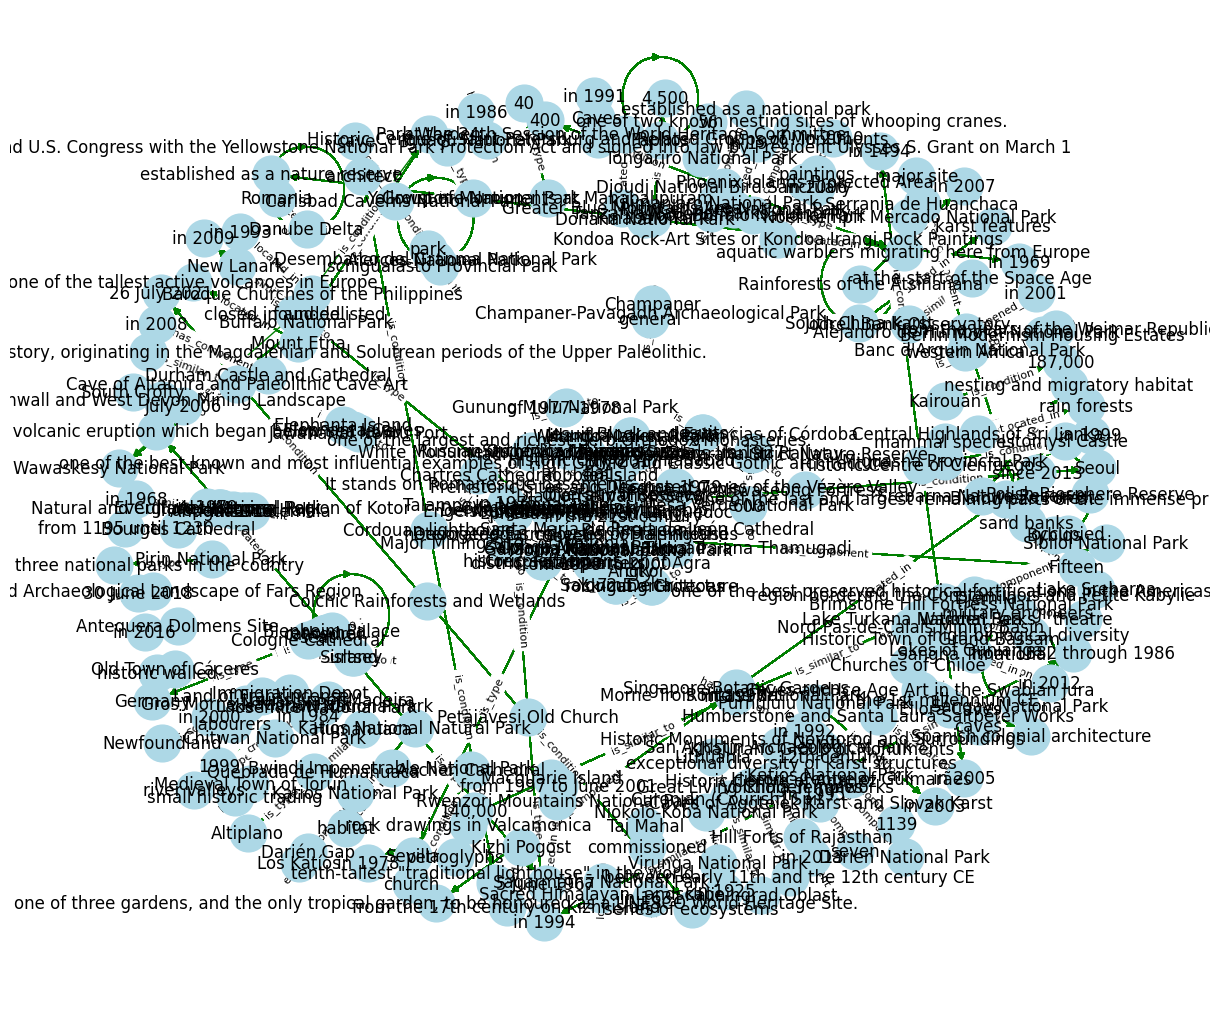

Query examples:
All nodes (entities):
('Ajanta Caves', {'labels': ['landmark_name']})
('rock-cut', {'labels': ['component']})
('Ephesus', {'labels': ['landmark_name']})
('built', {'labels': ['condition']})
('Robben Island', {'labels': ['landmark_name']})
('seals', {'labels': ['animal']})
('flat', {'labels': ['condition']})
('Surtsey', {'labels': ['location']})
('formed in a volcanic eruption which began below sea level', {'labels': ['condition']})
('5 June 1967', {'labels': ['date']})
('island', {'labels': ['type']})
('Yellowstone National Park', {'labels': ['landmark_name']})
('established by the 42nd U.S.\xa0Congress with the Yellowstone National Park Protection Act and signed into law by President Ulysses S. Grant on March 1', {'labels': ['condition']})
('Yosemite National Park', {'labels': ['landmark_name']})
('in 1984', {'labels': ['date']})
('Doñana National Park', {'labels': ['landmark_name']})
('established as a nature reserve', {'labels': ['condition']})
('in 1969', {'labels':

In [11]:
from knowledge_graph import knowledgeGraph
graph = knowledgeGraph()

if COMPONENT == 1:
    if COMPONENT_1_SUBSET == "titles":
        save_path = "unesco_titles_knowledge_graph.png"
    else:
        save_path = "unesco_pages_knowledge_graph.png"
else:
    save_path = "technical_knowledge_graph.png"

graph.draw_graph(all_relations=REL_TRIPLETS, all_data=NER_ENTS, store_graph=True, save_path=save_path)